In [1]:
from pennylane import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.insert(0, '/Users/tak/Github/QEmbedding/')
import Hybrid_nn
import torch
from torch import nn
import data
import pennylane as qml
import embedding

In [2]:
PATHs_Model2, PATHs_Model3 = [], []

for i in range(49):
    PATH_Model2 = f'/home/tak/Github/QEmbedding/Results/QCNN_demonstration/Real device/Real/Model2 pre-train/Model2_{i}.pt'
    PATH_Model3 = f'/home/tak/Github/QEmbedding/Results/QCNN_demonstration/Real device/Real/Model3 pre-train/Model3_{i}.pt'

    PATHs_Model2.append(PATH_Model2)
    PATHs_Model3.append(PATH_Model3)

In [3]:
def random_unitary(n):
    """
        Return a Haar distributed random unitary from U(N)
    """

    Z = np.random.randn(2**n, 2**n) + 1.0j * np.random.randn(2**n, 2**n)
    [Q, R] = np.linalg.qr(Z)
    D = np.diag(np.diagonal(R) / np.abs(np.diagonal(R)))
    return np.dot(Q, D)

def haar_integral(num_qubits, samples):
    """
        Return calculation of Haar Integral for a specified number of samples.
    """

    n = num_qubits
    randunit_density = np.zeros((4**n, 4**n), dtype=complex)

    
    zero_state = np.zeros(4**n, dtype=complex)
    zero_state[0] = 1
    
    for _ in range(samples):
        U = random_unitary(n)
        U = np.kron(U,U)
        A = np.matmul(zero_state, U).reshape(-1,1)
        randunit_density += np.kron(A, A.conj().T) 

    randunit_density/=samples

    return randunit_density

In [4]:
def kron(a, b):
    """
    Kronecker product of matrices a and b with leading batch dimensions.
    Batch dimensions are broadcast. The number of them mush
    :type a: torch.Tensor
    :type b: torch.Tensor
    :rtype: torch.Tensor
    """
    siz1 = torch.Size(torch.tensor(a.shape[-2:]) * torch.tensor(b.shape[-2:]))
    res = a.unsqueeze(-1).unsqueeze(-3) * b.unsqueeze(-2).unsqueeze(-4)
    siz0 = res.shape[:-4]
    return res.reshape(siz0 + siz1)

dev_sim = qml.device('default.qubit', wires=4)
@qml.qnode(dev_sim, interface="torch")
def circuit2(inputs): 
    embedding.Noisy_Four_QuantumEmbedding2(inputs)
    return qml.density_matrix(wires=range(4))

@qml.qnode(dev_sim, interface="torch")
def circuit1(inputs): 
    embedding.Noisy_Four_QuantumEmbedding1(inputs)
    return qml.density_matrix(wires=range(4))


class exp0(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer0 = qml.qnn.TorchLayer(circuit1, weight_shapes={})

    def forward(self, x):
        rhos = self.qlayer0(x)
        rhos = kron(rhos, rhos)
        rho = torch.sum(rhos, dim=0) / len(x)
        rho = rho.detach().numpy()
        exp = np.linalg.norm(rho - haar_integral(4, len(x)))
        return exp**2
    
    
class exp2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer2 = qml.qnn.TorchLayer(circuit2, weight_shapes={})
        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(4, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 7)
        )
    def forward(self, x):
        x = self.linear_relu_stack2(x)
        rhos = self.qlayer2(x)
        rhos = kron(rhos, rhos)
        rho = torch.sum(rhos, dim=0) / len(x)
        rho = rho.detach().numpy()
        exp = np.linalg.norm(rho - haar_integral(4, len(x)))
        return exp**2


class exp3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer3 = qml.qnn.TorchLayer(circuit2, weight_shapes={})
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 7
        self.fc = torch.nn.Linear(7 * 7, 7, bias=True)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1, 7 * 7)
        x = self.fc(x)
        rhos = self.qlayer3(x)
        rhos = kron(rhos, rhos)
        rho = torch.sum(rhos, dim=0) / len(x)
        rho = rho.detach().numpy()
        exp = np.linalg.norm(rho - haar_integral(4, len(x)))
        return exp**2

In [5]:
def expressibility(PATH, Model, X):
    if Model == 'Model2':
        model = exp2()
    elif Model == 'Model3':
        model = exp3()
    
    model.load_state_dict(torch.load(PATH))
    return model(X)

Expressibility without NQE

In [2]:
feature_reduction = 'PCA4'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
X_test =  torch.tensor(X_test).to(torch.float32)
X_train = torch.tensor(X_train).to(torch.float32)

/var/folders/s2/t3n82l2s329dh9dttmtv7vr00000gn/T/ipykernel_64835/2852941814.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  X_test =  torch.tensor(X_test).to(torch.float32)


In [3]:
print(X_train.shape, X_test.shape)

torch.Size([12665, 4]) torch.Size([2115, 4])


In [7]:
model0 = exp0()
exp_model0_train = model0(X_train)
exp_model0_test = model0(X_test)
print(f"Expressibility Train Data: {exp_model0_train}")
print(f"Expressibility Test Data: {exp_model0_test}")

/home/tak/anaconda3/envs/QC/lib/python3.11/site-packages/pennylane/qnn/torch.py:328: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  return self.qnode(**kwargs).type(x.dtype)


Expressibility Train Data: 0.01794292753845382
Expressibility Test Data: 0.019673749305534293


Expressibility with PCA-NQE

In [17]:
feature_reduction = 'PCA4'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
X_test =  torch.tensor(X_test).to(torch.float32)
X_train = torch.tensor(X_train).to(torch.float32)

In [9]:
Exp_history_Model2_Train = [expressibility(PATH=p, Model='Model2', X=X_train) for p in PATHs_Model2]
Exp_history_Model2_Test = [expressibility(PATH=p, Model='Model2', X=X_test) for p in PATHs_Model2]

KeyboardInterrupt: 

In [18]:
exp2_test = expressibility(PATH=PATHs_Model2[48], Model='Model2', X=X_test)
exp2_train = expressibility(PATH=PATHs_Model2[48], Model='Model2', X=X_train)

Expressibility with NQE

In [19]:
feature_reduction = False
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)
X_train, X_test = X_train.permute(0, 3, 1, 2), X_test.permute(0, 3, 1, 2)

In [20]:
exp3_train = expressibility(PATH=PATHs_Model3[48], Model='Model3', X=X_test)
exp3_test = expressibility(PATH=PATHs_Model3[48], Model='Model3', X=X_train)

In [21]:
print(f"Expressibility PCA-NQE (Train): {exp2_train}")
print(f"Expressibility PCA-NQE (Test): {exp2_test}")
print(f"Expressibility NQE (Train): {exp3_train}")
print(f"Expressibility NQE (Test): {exp3_test}")

Expressibility PCA-NQE (Train): 0.14135069046185675
Expressibility PCA-NQE (Test): 0.14250309189831342
Expressibility NQE (Train): 0.13178034856598564
Expressibility NQE (Test): 0.13071623172235433


In [ ]:
Exp_history_Model3_Train = [expressibility(PATH=p, Model='Model3', X=X_train) for p in PATHs_Model3]
Exp_history_Model3_Test = [expressibility(PATH=p, Model='Model3', X=X_test) for p in PATHs_Model3]

In [ ]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 13})
fig, (ax1, ax2) = plt.subplots(1,2)
clrs = sns.color_palette("husl", 3)
with sns.axes_style("darkgrid"):
    ax1.scatter(range(49), Exp_history_Model2_Train, marker="o", label="PCA-NQE", c=clrs[0])
    ax1.scatter(range(49), Exp_history_Model3_Train, marker="^", label="NQE", c=clrs[1])
    ax1.plot(range(49), np.ones(49) * exp_model0_train, linestyle='dashed', linewidth=1.5, label="Without NQE", c=clrs[2])
    
    ax2.scatter(range(49), Exp_history_Model2_Test, marker="o", label="PCA-NQE", c=clrs[0])
    ax2.scatter(range(49), Exp_history_Model3_Test, marker="^", label="NQE", c=clrs[1])
    ax2.plot(range(49), np.ones(49) * exp_model0_test, linestyle='dashed', linewidth=1.5, label="Without NQE", c=clrs[2])

ax1.set_xlabel("Iteration")
ax1.set_ylabel("Expressibility")
ax1.set_title("Training data")
ax1.legend(fontsize=12)

ax2.set_xlabel("Iteration")
ax2.set_ylabel("Expressibility (2-design)")
ax2.set_title("Test data")
ax2.legend(fontsize=12)

plt.savefig("Expressibility2.pdf")

In [ ]:
f = open("Expressibility2.txt", "w")
f.write(f"Expressibility without NQE (Train): {exp_model0_train}\n")
f.write(f"Expressibility without NQE (Test): {exp_model0_test}\n")
f.write("\n")
f.write(f"Expressibility with PCA-NQE (Train):\n")
f.write(str(Exp_history_Model2_Train))
f.write("\n")
f.write(f"Expressibility with PCA-NQE (Test):\n")
f.write(str(Exp_history_Model2_Test))
f.write("\n")
f.write(f"Expressibility with NQE (Train):\n")
f.write(str(Exp_history_Model3_Train))
f.write("\n")
f.write(f"Expressibility with NQE (Test):\n")
f.write(str(Exp_history_Model3_Test))
f.write("\n")
f.close()

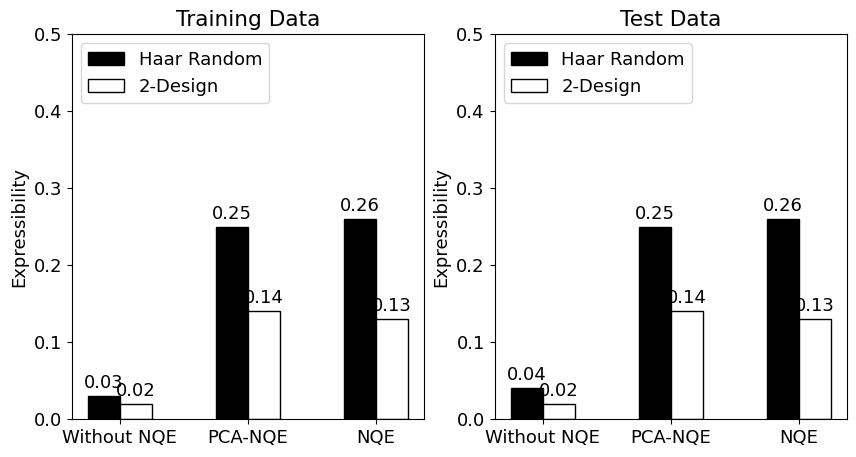

<Figure size 1000x500 with 0 Axes>

In [67]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 13})
fig, (ax1, ax2) = plt.subplots(1,2)
clrs = sns.color_palette("husl", 3)
with sns.axes_style("darkgrid"):
    X = ("Without NQE","PCA-NQE", "NQE")
    expressibility_Train = {
        'Haar Random': (0.03, 0.25, 0.26),
        '2-Design': (0.02, 0.14, 0.13),
    }
    expressibility_Test = {
        'Haar Random': (0.04, 0.25, 0.26),
        '2-Design': (0.02, 0.14, 0.13),
    }

x = np.arange(len(X))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0


for attribute, measurement in expressibility_Train.items():
    if attribute == 'Haar Random':
        color = "black"
    else:
        color = "white"
    offset = width * multiplier
    rects = ax1.bar(x + offset, measurement, width, label=attribute, color=color, edgecolor='black')
    ax1.bar_label(rects, padding=3)
    multiplier += 1

x = np.arange(len(X))  # the label locations
width = 0.25 # the width of the bars
multiplier = 0

for attribute, measurement in expressibility_Test.items():
    if attribute == 'Haar Random':
        color = "black"
    else:
        color = "white"
    offset = width * multiplier
    rects = ax2.bar(x + offset, measurement, width, label=attribute, color=color, edgecolor='black')
    ax2.bar_label(rects,padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Expressibility')
ax1.set_title('Training Data')
ax1.set_xticks(x + width - 0.125, X)
ax1.legend(loc='upper left', ncols=1, fontsize=13)
ax1.set_ylim(0, 0.5)

ax2.set_ylabel('Expressibility')
ax2.set_title('Test Data')
ax2.set_xticks(x + width - 0.125, X)
ax2.legend(loc='upper left', ncols=1, fontsize=13)
ax2.set_ylim(0, 0.5)

plt.show()




plt.savefig("Expressibility.pdf")